In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from __future__ import annotations
import numpy as np

from mflex.simulate.simulate_boundary import dipole

from mhsflex.field2d import Field2dData
from mhsflex.field3d import Field3dData, calculate_magfield, lf3d, j3d
from mhsflex.vis import plot, plot_plasma_parameters
from mhsflex.metrics import compare_field3d

from matplotlib import rc, colors
import matplotlib.pyplot as plt

from mflex.model.field.utility.poloidal import (
    phi,
    phi_low,
    phi_hypgeo,
    dphidz_hypgeo,
    dphidz,
    dphidz_low,
)

rc("font", **{"family": "serif", "serif": ["Times"]})
rc("text", usetex=True)

c1 = (0.439, 0.788, 1.000)
c2 = (0.420, 0.502, 1.000)
c3 = "black"
c4 = (1.000, 0.224, 0.376)
c5 = (0.784, 0.231, 0.576)
c7 = (0.992, 0.251, 0.733)
c8 = (0.867, 0.871, 0.184)
c9 = (0.949, 0.922, 0.678)
c10 = (0.984, 0.455, 0.231)
c11 = (0.765, 0.835, 0.922)
c12 = (0.965, 0.694, 0.486)
c13 = (0.992, 0.584, 0.820)

/Users/lilli/Library/Caches/pypoetry/virtualenvs/mflex-cNoQEf_u-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nresol_x = 200
nresol_y = 200
nresol_z = 400
xmin = 0.0
xmax = 20.0  # in units of 10^4 km, therefore corresponds to 20Mm
ymin = 0.0
ymax = 20.0
zmin = 0.0
zmax = 20.0
pixelsize_x = (xmax - xmin) / nresol_x
pixelsize_y = (ymax - ymin) / nresol_y
pixelsize_z = (zmax - zmin) / nresol_z

z0 = 2.0

nf_max = 200

z_arr = np.arange(nresol_z) * (zmax - zmin) / (nresol_z - 1) + zmin
x_arr = np.arange(nresol_x) * (xmax - xmin) / (nresol_x - 1) + xmin
y_arr = np.arange(nresol_y) * (ymax - ymin) / (nresol_y - 1) + ymin
B_PHOTO = 500
data_bz = np.zeros((nresol_y, nresol_x))

for ix in range(0, nresol_x):
    for iy in range(0, nresol_y):
        x = x_arr[ix]
        y = y_arr[iy]
        data_bz[iy, ix] = dipole(x, y) * B_PHOTO

data2d = Field2dData(
    nresol_x,
    nresol_y,
    nresol_z,
    nresol_x,
    pixelsize_x,
    pixelsize_y,
    pixelsize_z,
    x_arr,
    y_arr,
    z_arr,
    data_bz,
)

In [122]:
a = 0.22
alpha = 0.05
b = 1.0
z0 = 2.0

In [123]:
length_scale = float(2.0)  # Normalising length scale for Seehafer

length_scale_x = 2.0 * nresol_x * data2d.px
length_scale_y = 2.0 * nresol_y * data2d.py

length_scale_x_norm = length_scale_x / length_scale
length_scale_y_norm = length_scale_y / length_scale

kx_arr = np.arange(data2d.nf) * np.pi / length_scale_x_norm  # [0:nf_max]
ky_arr = np.arange(data2d.nf) * np.pi / length_scale_y_norm  # [0:nf_max]
one_arr = 0.0 * np.arange(data2d.nf) + 1.0

ky_grid = np.outer(ky_arr, one_arr)  # [0:nf_max, 0:nf_max]
kx_grid = np.outer(one_arr, kx_arr)  # [0:nf_max, 0:nf_max]

# kx^2 + ky^2

k2_arr = np.outer(ky_arr**2, one_arr) + np.outer(one_arr, kx_arr**2)
k2_arr[0, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[1, 0] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2
k2_arr[0, 1] = (np.pi / length_scale_x_norm) ** 2 + (np.pi / length_scale_y_norm) ** 2

# Need k^2 > alpha^2/(1-2a) and k^2 > alpha^2

limit = (k2_arr - alpha**2) / (2 * k2_arr)

In [124]:
(k2_arr.min() - alpha**2) / (2 * k2_arr.min())

0.47466970408941556

In [125]:
phi_asymp = np.zeros((nf_max, nf_max, nresol_z))
dphidz_asymp = np.zeros((nf_max, nf_max, nresol_z))
phi_hyper = np.zeros((nf_max, nf_max, nresol_z))
dphidz_hyper = np.zeros((nf_max, nf_max, nresol_z))

In [174]:
deltaz = 0.2

p_arr = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a - a * b) - alpha**2)
)
q_arr = (
    0.5 * deltaz * np.sqrt(k2_arr[0:nf_max, 0:nf_max] * (1.0 - a + a * b) - alpha**2)
)

In [175]:
for iz, z in enumerate(z_arr):
    phi_asymp[:, :, iz] = phi(z, p_arr, q_arr, z0, deltaz)
    dphidz_asymp[:, :, iz] = dphidz(z, p_arr, q_arr, z0, deltaz)

In [176]:
for iz, z in enumerate(z_arr):
    phi_hyper[:, :, iz] = phi_hypgeo(z, p_arr, q_arr, z0, deltaz)
    dphidz_hyper[:, :, iz] = dphidz_hypgeo(z, p_arr, q_arr, z0, deltaz)

In [177]:
folder = "/Users/lilli/Desktop/Thesis/Performance/Phi/" + str(a) + "/" + str(deltaz)

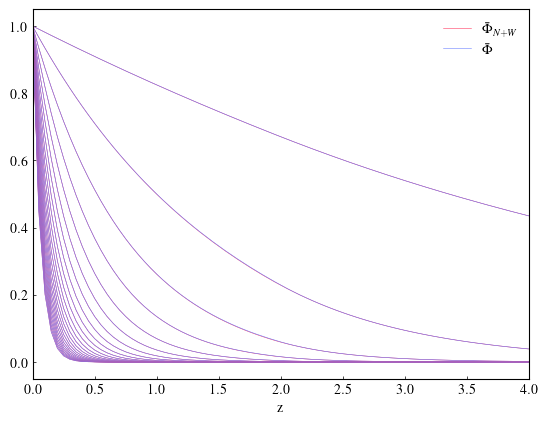

In [178]:
for ix in range(4, 100, 4):
    plt.plot(
        z_arr,
        phi_hyper[ix, ix, :],
        linewidth=0.4,
        color=c4,
        # label="N+W (2019)"
    )
    plt.plot(
        z_arr,
        phi_asymp[ix, ix, :],
        linewidth=0.4,
        color=c2,
        # label="N+N (2024)",
    )
plt.plot(
    z_arr,
    phi_hyper[0, 0, :],
    linewidth=0.4,
    color=c4,
    label=r"$\bar\Phi_{N+W}$",
)
plt.plot(
    z_arr,
    phi_asymp[0, 0, :],
    linewidth=0.4,
    color=c2,
    label=r"$\bar\Phi$",
)
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
# plt.ylabel(r"$\bar{\Phi}$")
plotname = folder + "/phi_faecher.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

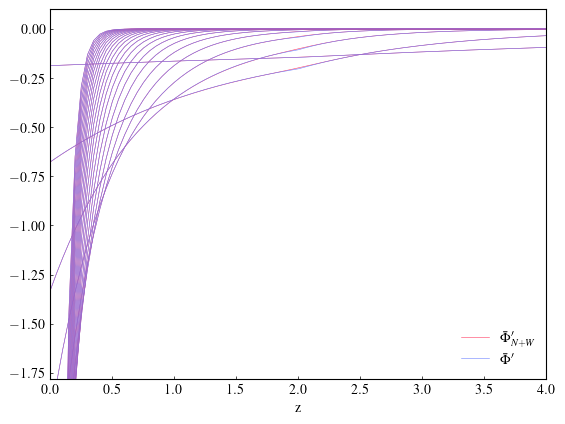

In [179]:
for ix in range(4, 100, 4):
    plt.plot(
        z_arr,
        dphidz_hyper[ix, ix, :],
        linewidth=0.4,
        color=c4,
        # label="N+W (2019)"
    )
    plt.plot(
        z_arr,
        dphidz_asymp[ix, ix, :],
        linewidth=0.4,
        color=c2,
        # label="N+N (2024)",
    )

plt.plot(
    z_arr,
    dphidz_hyper[0, 0, :],
    linewidth=0.4,
    color=c4,
    label=r"$\bar\Phi_{N+W}'$",
)
plt.plot(
    z_arr,
    dphidz_asymp[0, 0, :],
    linewidth=0.4,
    color=c2,
    label=r"$\bar\Phi'$",
)
plt.xlim([0, 2 * z0])
plt.legend(frameon=False)
plt.xlabel("z")
plotname = folder + "/dphidz_faecher.png"
plt.ylim([-1.78, 0.1])
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [180]:
abserrphi = np.zeros_like(phi_asymp)
abserrdphi = np.zeros_like(phi_asymp)
relerrphi = np.zeros_like(phi_asymp)
relerrdphi = np.zeros_like(phi_asymp)

In [181]:
for ix in range(nf_max):
    for iy in range(nf_max):
        for iz in range(nresol_z):

            abserrphi[iy, ix, iz] = abs(phi_hyper[iy, ix, iz] - phi_asymp[iy, ix, iz])

            abserrdphi[iy, ix, iz] = abs(
                dphidz_hyper[iy, ix, iz] - dphidz_asymp[iy, ix, iz]
            )

            relerrphi[iy, ix, iz] = abs(
                phi_hyper[iy, ix, iz] - phi_asymp[iy, ix, iz]
            ) / abs(phi_asymp[iy, ix, iz])

            relerrdphi[iy, ix, iz] = abs(
                dphidz_hyper[iy, ix, iz] - dphidz_asymp[iy, ix, iz]
            ) / abs(dphidz_asymp[iy, ix, iz])

/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7493/3348697439.py:11: RuntimeWarning: invalid value encountered in scalar divide
  relerrphi[iy, ix, iz] = abs(
/var/folders/cr/r56x0z910tncp30pdz4343cm0000gn/T/ipykernel_7493/3348697439.py:15: RuntimeWarning: invalid value encountered in scalar divide
  relerrdphi[iy, ix, iz] = abs(


In [182]:
abserrphi_max = np.zeros_like(z_arr)
abserrphi_min = np.zeros_like(z_arr)

abserrdphi_max = np.zeros_like(z_arr)
abserrdphi_min = np.zeros_like(z_arr)

relerrphi_max = np.zeros_like(z_arr)
relerrphi_min = np.zeros_like(z_arr)

relerrdphi_max = np.zeros_like(z_arr)
relerrdphi_min = np.zeros_like(z_arr)

In [183]:
for iz in range(nresol_z):

    abserrphi_max[iz] = abserrphi[:, :, iz].max()
    abserrphi_min[iz] = abserrphi[:, :, iz].min()

    abserrdphi_max[iz] = abserrdphi[:, :, iz].max()
    abserrdphi_min[iz] = abserrdphi[:, :, iz].min()

    relerrphi_max[iz] = relerrphi[:, :, iz].max()
    relerrphi_min[iz] = relerrphi[:, :, iz].min()

    relerrdphi_max[iz] = relerrdphi[:, :, iz].max()
    relerrdphi_min[iz] = relerrdphi[:, :, iz].min()

In [184]:
abserrphi_surf = np.zeros((nf_max, nf_max))
relerrphi_surf = np.zeros_like(abserrphi_surf)

In [185]:
for ix in range(nf_max):
    for iy in range(nf_max):
        abserrphi_surf[iy, ix] = abserrphi[iy, ix, :].max()
        relerrphi_surf[iy, ix] = relerrphi[iy, ix, :].max()

In [186]:
errormap = colors.LinearSegmentedColormap.from_list(
    "my_gradient",
    (
        # Edit this gradient at https://eltos.github.io/gradient/#FFFDFD-4B4B4B
        (0.000, (1.000, 1.0, 1.0)),
        (1.000, (0.820, 0.522, 1.000)),
    ),
)

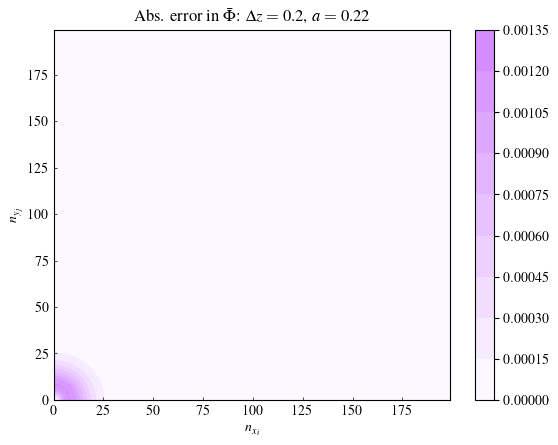

In [187]:
plt.contourf(abserrphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$n_{x_i}$")
plt.ylabel(r"$n_{y_j}$")
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = folder + "/phi_ae_fm.png"
plt.title(
    r"Abs. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

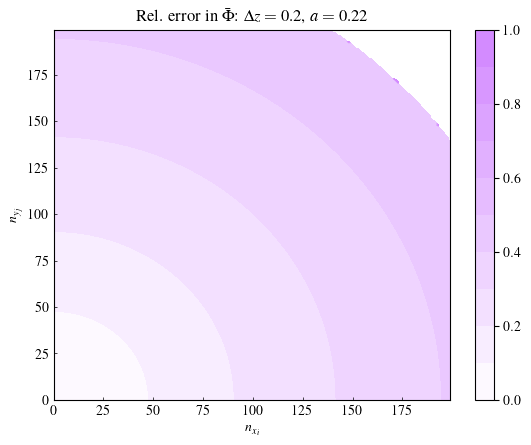

In [188]:
plt.contourf(relerrphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$n_{x_i}$")
plt.ylabel(r"$n_{y_j}$")
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = folder + "/phi_re_fm.png"
plt.title(
    r"Rel. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [189]:
abserrdphi_surf = np.zeros((nf_max, nf_max))
relerrdphi_surf = np.zeros((nf_max, nf_max))

for ix in range(nf_max):
    for iy in range(nf_max):
        abserrdphi_surf[iy, ix] = abserrdphi[iy, ix, :].max()
        relerrdphi_surf[iy, ix] = relerrdphi[iy, ix, :].max()

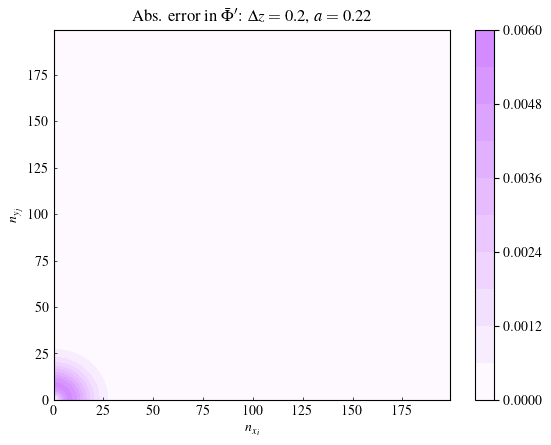

In [190]:
plt.contourf(abserrdphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$n_{x_i}$")
plt.ylabel(r"$n_{y_j}$")
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = folder + "/dphi_ae_fm.png"
plt.title(
    r"Abs. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

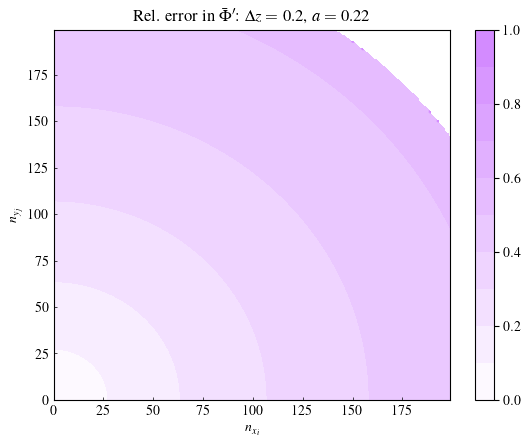

In [191]:
plt.contourf(relerrdphi_surf, levels=10, cmap=errormap)
plt.colorbar()
# plt.legend()
plt.xlabel(r"$n_{x_i}$")
plt.ylabel(r"$n_{y_j}$")
plt.title(
    r"Rel. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
# plt.ylabel(r"$| \overline{\Phi}_{N+W} - \overline{\Phi} | $")
plotname = folder + "/dphi_re_fm.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

In [192]:
meanerror = np.mean(abserrphi, axis=(0, 1))
std = np.std(abserrphi, axis=(0, 1))

meanerrordp = np.mean(abserrdphi, axis=(0, 1))
stddp = np.std(abserrdphi, axis=(0, 1))

meanerrorr = np.mean(relerrphi, axis=(0, 1))
stdr = np.std(relerrphi, axis=(0, 1))

meanerrordpr = np.mean(relerrdphi, axis=(0, 1))
stddpr = np.std(relerrdphi, axis=(0, 1))

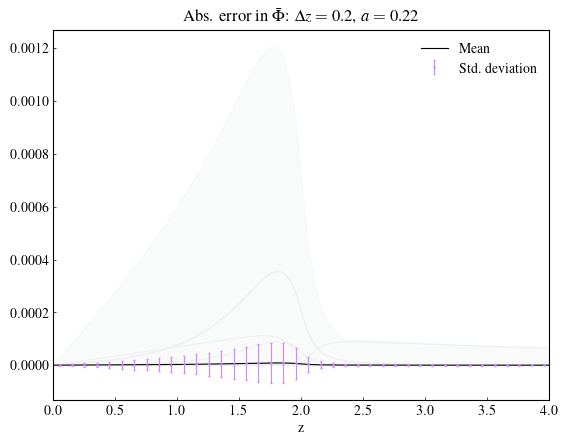

In [193]:
plt.fill_between(
    data2d.z, abserrphi_min, abserrphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            abserrphi[iy, ix, :],
            linewidth=0.8,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerror, linewidth=0.8, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerror[np.arange(1, len(meanerrordpr), 2)],
    std[np.arange(1, len(meanerrordpr), 2)],
    marker="o",
    markersize=0.8,
    linestyle="None",
    linewidth=0.8,
    color=(0.820, 0.522, 1.000),
    capsize=0.8,
    label="Std. deviation",
)


plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
# plt.ylabel(r"Abs. error $\bar{\Phi}$")
plt.title(
    r"Abs. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plotname = folder + "/phi_abserr1.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

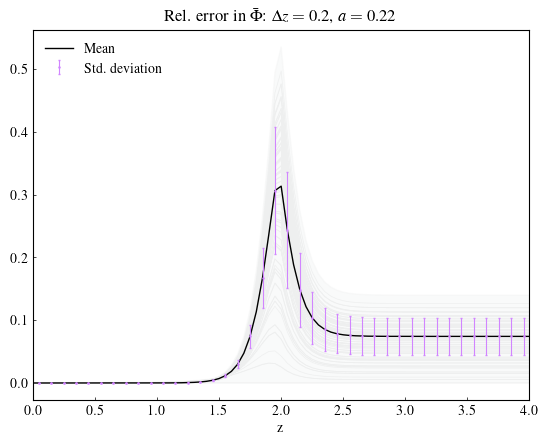

In [194]:
plt.fill_between(
    data2d.z, relerrphi_min, relerrphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            relerrphi[iy, ix, :],
            linewidth=0.5,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerrorr, linewidth=1.0, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerrorr[np.arange(1, len(meanerrordpr), 2)],
    stdr[np.arange(1, len(meanerrordpr), 2)],
    linestyle="None",
    marker="o",
    markersize=0.8,
    linewidth=0.8,
    color=(0.820, 0.522, 1.000),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
# plt.ylabel(r"Rel. error $\bar{\Phi}$")
plt.title(
    r"Rel. error in $\bar{\Phi}$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plotname = folder + "/phi_relerr1.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False, loc=2)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

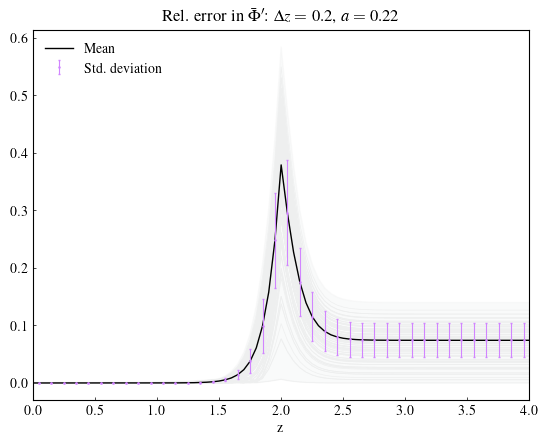

In [195]:
plt.fill_between(
    data2d.z, relerrdphi_min, relerrdphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            relerrdphi[iy, ix, :],
            linewidth=0.5,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerrordpr, linewidth=1.0, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerrordpr[np.arange(1, len(meanerrordpr), 2)],
    stddpr[np.arange(1, len(meanerrordpr), 2)],
    linestyle="None",
    marker="o",
    markersize=0.8,
    linewidth=0.8,
    color=(0.820, 0.522, 1.000),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
# plt.ylabel(r"Rel. error $\bar{\Phi}'$")
plt.title(
    r"Rel. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plotname = folder + "/dphi_relerr1.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False,  loc=2)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()

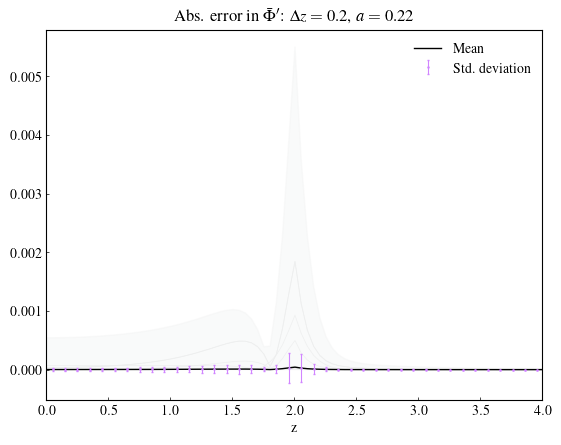

In [196]:
plt.fill_between(
    data2d.z, abserrdphi_min, abserrdphi_max, color=(0.933, 0.937, 0.937), alpha=0.3
)
for ix in range(0, nf_max, 20):
    for iy in range(0, nf_max, 20):
        plt.plot(
            z_arr,
            abserrdphi[iy, ix, :],
            linewidth=0.5,
            color=(0.933, 0.937, 0.937),
            # alpha=0.5
        )
plt.plot(z_arr, meanerrordp, linewidth=1.0, color="black", label="Mean")
plt.errorbar(
    z_arr[np.arange(1, len(meanerrordpr), 2)],
    meanerrordp[np.arange(1, len(meanerrordpr), 2)],
    stddp[np.arange(1, len(meanerrordpr), 2)],
    linestyle="None",
    marker="o",
    markersize=0.8,
    linewidth=0.8,
    color=(0.820, 0.522, 1.000),
    capsize=0.8,
    label="Std. deviation",
)

plt.xlim([0, 2 * z0])
# plt.legend()
plt.xlabel("z")
# plt.ylabel(r"Abs. error $\bar{\Phi}'$")
plt.title(
    r"Abs. error in $\bar{\Phi}'$: $\Delta z = $ " + str(deltaz) + r", $a = $ " + str(a)
)
plotname = folder + "/dphi_abserr1.png"
plt.tick_params(direction="in", length=2, width=0.5)
plt.legend(frameon=False)
plt.savefig(plotname, dpi=300, bbox_inches="tight", pad_inches=0.1)
plt.show()